In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

(512, 512, 512)


Text(0.5, 1.0, 'Lagrangian Density pre re-ion')

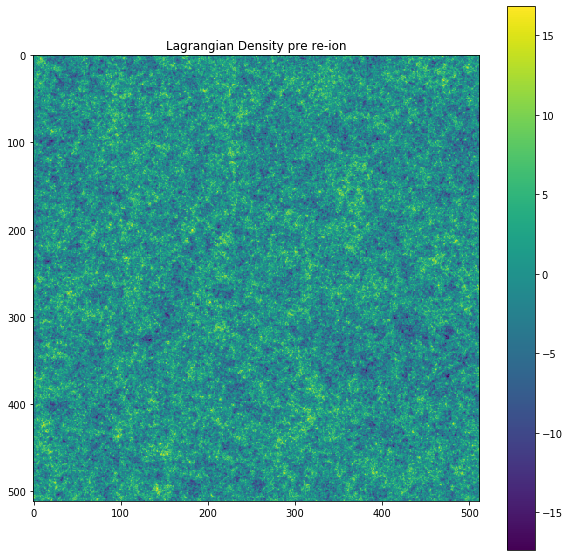

In [58]:
N = 512
datadir = '/global/cscratch1/sd/tmedan/notebooks/'
# datadir = '../multiseed_runs/run0/Boxes/'

freion = open(datadir+'reionization/reion_05')
fdensL  = open(datadir+'density_Lag/dens_05')
fdensE  = open(datadir+'density_Eul/dens_05')

densL = np.fromfile(fdensL, count=N**3, dtype=np.float32).reshape(N,N,N)
densE = np.fromfile(fdensE, count = N**3, dtype=np.float32).reshape(N,N,N)
reion = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)


print(densL.shape)
plt.figure(figsize = (10,10))
plt.imshow(densL[0])
plt.colorbar()
plt.title('Lagrangian Density pre re-ion')

In [59]:
#scaling class for use in the vision linear network to image ionization

class ScaleField(): #this is just utilizing storing the max min and average values of 
    #the strict data set!
    # used MEAN NORMALIZATION HERE ONLY 
    def __init__(self, field):
        super(ScaleField, self).__init__()

        self.fmin  = field.min()
        self.fmax  = field.max() 
        self.fmean = field.mean()
    
    
    def scale(self, field): 
            return (field - self.fmean) / (self.fmax - self.fmin)
        
densL_scaled = ScaleField(densL).scale(field=densL)
densE_scaled = ScaleField(densE).scale(field=densE)
reion_scaled = ScaleField(reion).scale(field=reion)

print(densL_scaled.shape)

(512, 512, 512)


In [44]:

def cubify(arr, newshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    oldshape = np.array(arr.shape)
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

def uncubify(arr, oldshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    N, newshape = arr.shape[0], arr.shape[1:]
    oldshape = np.array(oldshape)    
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.concatenate([repeats, newshape])
    order = np.arange(len(tmpshape)).reshape(2, -1).ravel(order='F')
    return arr.reshape(tmpshape).transpose(order).reshape(oldshape)

In [ ]:
# def model

# model = tfk.Sequential()

# model.add(tfkl.Conv3D(
#     filters = filters_num, kernel_size = ker, strides=(1, 1, 1), padding='same', 
#     activation='relu',input_shape = (512,512,512,1) ))
# model.add(tfkl.BatchNormalization())

# model.add(tfkl.Conv3D(
#         filters = filters_num,kernel_size = ker, strides=(1, 1, 1), padding='same', 
#         activation='relu',input_shape = (512,512,512,1) ))
# model.add(tfkl.BatchNormalization())




In [60]:
n_filters = 36

img_shape = 32

Input_shape=(img_shape,img_shape,img_shape,1)

model = tfk.Sequential()
    
model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(5,5,5),
                     strides=(1,1,1),
                     use_bias=True,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.Activation('relu'))

model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(3,3,3),
                     strides=(1,1,1),
                     use_bias=True,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.Activation('relu'))

model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(3,3,3),
                     strides=(1,1,1),
                     use_bias=True,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.LeakyReLU(alpha = 0.3))

model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(1,1,1),
                     strides=(1,1,1),
                     use_bias=True,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.LeakyReLU(alpha = 0.3))

model.add(tfkl.Conv3D(filters=1,
                     kernel_size=(1,1,1),
                     strides=(1,1,1),
                     use_bias=False,padding= 'same'))
model.add(tfkl.Activation('relu'))

model.summary()

#try without bias, vector increase, possible non-use of cube slice pre-process?


## ADD IN A RES NET FACTOR, PLAY AROUND WITH FILTERS AND KERNALS AND NUMBER
## OF LAYERS AS WELL
## LOOK UP HOW TO UPSAMPLE ONCE I DOWNSAMPLE WHICH USES STRIDES GREATER
##GREATER THAN 1
## TRY TO IMPLEMENT SOME SORT OF BAYESIAN NETWORK FACTOR INTO THIS




Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 32, 32, 32, 36)    4536      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32, 36)    144       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32, 36)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 32, 32, 32, 36)    35028     
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32, 36)    144       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32, 36)    0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 32, 32, 32, 36)   

(4096, 32, 32, 32, 1)


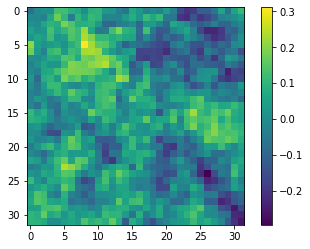

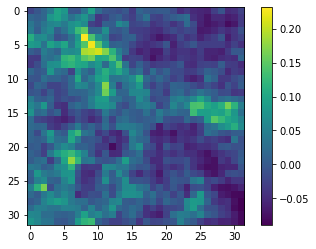

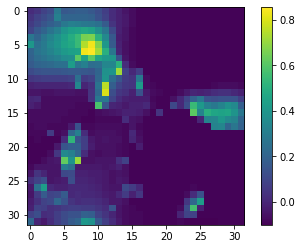

In [61]:
#training data
img_shape = 32

densL_train = cubify(densL_scaled,(img_shape,img_shape,img_shape))[..., np.newaxis]
densE_train = cubify(densE_scaled,(img_shape,img_shape,img_shape))[..., np.newaxis]
reion_train = cubify(reion_scaled,(img_shape,img_shape,img_shape))[..., np.newaxis]

print(reion_train.shape)

plt.figure()
plt.imshow(densL_train[0,0,...,0])
plt.colorbar()

plt.figure()
plt.imshow(densE_train[0,0,...,0])
plt.colorbar()

plt.figure()
plt.imshow(reion_train[0,0,...,0])
plt.colorbar()

Epoch 1/50
116/116 [==============================] - 14s 117ms/step - loss: 0.0116 - accuracy: 0.0000e+00 - val_loss: 0.0159 - val_accuracy: 0.0000e+00
Epoch 2/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0060 - accuracy: 0.0000e+00 - val_loss: 0.0159 - val_accuracy: 0.0000e+00
Epoch 3/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0156 - val_accuracy: 0.0000e+00
Epoch 4/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0138 - val_accuracy: 0.0000e+00
Epoch 5/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0097 - val_accuracy: 0.0000e+00
Epoch 6/50
116/116 [==============================] - 13s 116ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0061 - val_accuracy: 0.0000e+00
Epoch 7/50
116/116 [==============================] - 13s 115ms/step - loss: 0.005

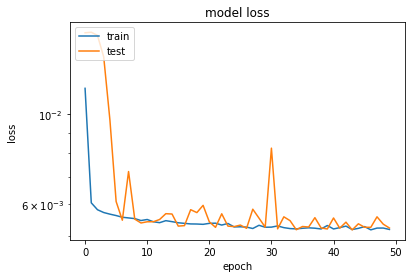

In [ ]:
optimizer = tfk.optimizers.Adam(1e-3)
model.compile(optimizer=optimizer, loss="mse", metrics = ['accuracy'])

history = model.fit(densE_train, reion_train,
               epochs=50, validation_split = 0.1, verbose = 1)

print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('5_layer_CNN_trainplot')
plt.show()

In [53]:
#model.save('5_layer_CNN')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 5_layer_CNN/assets


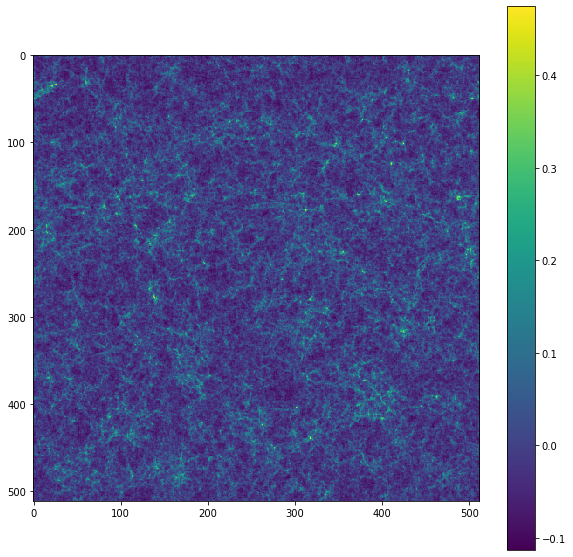

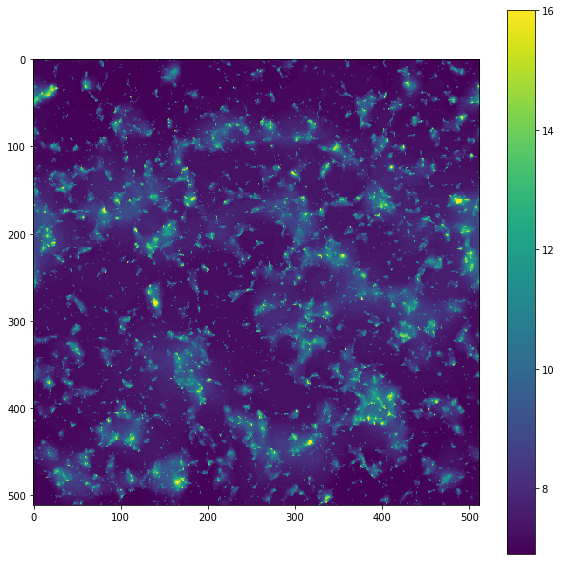

In [63]:
# get test data

datadir = '/global/cscratch1/sd/tmedan/notebooks/'

freion = open(datadir+'reionization/reion_06')
fdens  = open(datadir+'density_Eul/dens_06')

x_test  = np.fromfile(fdens, count=N**3, dtype=np.float32).reshape(N,N,N)
y_test  = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)

density_scaling_test      = ScaleField(x_test)
reionization_scaling_test = ScaleField(y_test)

x_test = density_scaling_test.scale(field=x_test)


plt.figure(figsize=(10,10))
plt.imshow(x_test[0])
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(y_test[0])
plt.colorbar()

x_test = cubify(x_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]
y_test = cubify(y_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]

In [64]:
y_test_predict = model.predict(x_test)

In [65]:
y_test_predict = reionization_scaling_test.scale(field=y_test_predict)
#y_test = reionization_scaling_test.scale(field=y_test)

In [66]:
yshow_predict = y_test_predict[0,img_shape//2, ..., 0]
yshow = y_test[0,img_shape//2, ..., 0]

xshow = x_test[0,img_shape//2, ..., 0]

ymin = yshow.min()
ymax = yshow.max()

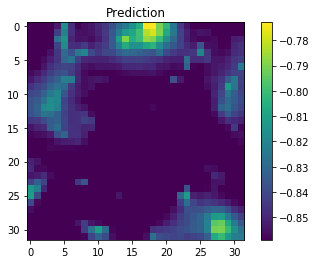

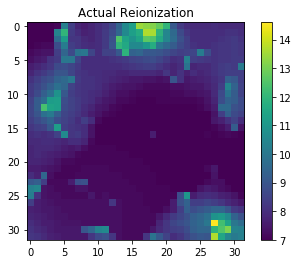

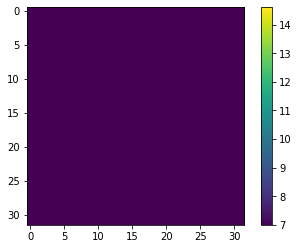

In [67]:
plt.figure()
plt.imshow(yshow_predict)
plt.title('Prediction')
plt.colorbar()
plt.savefig('5_layer_CNN_predict')


plt.figure()
plt.imshow(yshow)
plt.title('Actual Reionization')
plt.colorbar()
plt.savefig('5_layer_CNN_actual')


plt.figure()
plt.imshow(yshow_predict,vmin = ymin, vmax = ymax)
plt.colorbar()
